## Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import joblib
from collections import Counter
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Load The Model & Scaler & Threshold

In [2]:
# Final optimized thresholds
final_thresholds = [0.30, 0.30, 0.38, 0.38, 0.72]  

# Save thresholds
joblib.dump(final_thresholds, "final_thresholds.pkl")

print("✅ Final thresholds saved successfully!")

✅ Final thresholds saved successfully!


In [3]:
# Load the trained CatBoost model (latest version)
catb = joblib.load("catboost_model.pkl")

# Load the final optimized thresholds
final_thresholds = joblib.load("final_thresholds.pkl")

# Load the scaler (used during training)
scaler = joblib.load("scaler.pkl")

print("Model, scaler, and thresholds loaded successfully!")

Model, scaler, and thresholds loaded successfully!


## Load & Preprocess Test Data

In [4]:
# Load test dataset
df_test = pd.read_csv("predictive_maintenance.csv")

# Drop unnecessary columns to match training features
df_test.drop(['Product ID', 'UDI', 'Target'], axis=1, inplace=True)

# Encode categorical variables
df_test["Failure Type"].replace({
    "No Failure": 0, "Heat Dissipation Failure": 1, "Power Failure": 2,
    "Overstrain Failure": 3, "Tool Wear Failure": 4, "Random Failures": 5
}, inplace=True)

df_test["Type"].replace({"H": 0, "L": 1, "M": 2}, inplace=True)

# Define features (X) and labels (y)
X_test = df_test.drop(columns=["Failure Type"])
y_test = df_test["Failure Type"]

# Scale test features
X_test_scaled = scaler.transform(X_test)

print("✅ Test data loaded and scaled successfully!")

✅ Test data loaded and scaled successfully!


C:\Users\singh\AppData\Local\Temp\ipykernel_20096\1998258650.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test["Failure Type"].replace({
C:\Users\singh\AppData\Local\Temp\ipykernel_20096\1998258650.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test["Failure Type"].replace({
C:\Use

## Model Predictions with Thresholds

In [5]:
# Get probability predictions from the model
test_pred_proba = catb.predict_proba(X_test_scaled)

# Create a new prediction array (default: "No Failure" (0))
test_pred_adjusted = np.zeros(len(test_pred_proba), dtype=int)

# Apply optimized thresholds
for i in range(5):  
    test_pred_adjusted[test_pred_proba[:, i+1] > final_thresholds[i]] = i + 1

# Print prediction distribution
test_prediction_counts_adjusted = Counter(test_pred_adjusted)
print("✅ Final Prediction Distribution:", test_prediction_counts_adjusted)

✅ Final Prediction Distribution: Counter({np.int64(0): 5552, np.int64(5): 2506, np.int64(4): 872, np.int64(1): 527, np.int64(2): 272, np.int64(3): 271})


## Normal Operating Ranges for Machine Features

## Failure Type Mapping

In [6]:
# Failure type mapping
failure_mapping = {
    0: "No Failure",
    1: "Heat Dissipation Failure",
    2: "Power Failure",
    3: "Tool Wear Failure",
    4: "Overstrain Failure",
    5: "Random Failures"
}
# Defining column names (same as training features)
feature_columns = ['Type', 'Air temperature [K]', 'Process temperature [K]', 
                   'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

## Testing Predifined Safe Case

In [7]:
# Safe Case Test
safe_case = pd.DataFrame([[1, 298.1, 308.6, 1500, 40.0, 5.0]], columns=feature_columns)
safe_case_scaled = scaler.transform(safe_case)

safe_pred_proba = catb.predict_proba(safe_case_scaled)
safe_pred = 0
for i in range(5):
    if safe_pred_proba[0, i+1] > final_thresholds[i]:
        safe_pred = i + 1

print("Prediction:", failure_mapping[safe_pred])

Prediction: No Failure


## Testing Predifined Failure Case

In [8]:
# Fail Case Test
failure_case = pd.DataFrame([[2, 310, 320, 1000, 60, 50]], columns=feature_columns)

# Scale the input
failure_case_scaled = scaler.transform(failure_case)

# Get probability predictions
failure_pred_proba = catb.predict_proba(failure_case_scaled)

# Apply optimized thresholds
failure_pred = 0
for i in range(5):
    if failure_pred_proba[0, i+1] > final_thresholds[i]:
        failure_pred = i + 1

# Print final mapped prediction
print("Prediction:", failure_mapping[failure_pred])

Prediction: Heat Dissipation Failure


In [9]:
#Failure Case Test
failure_case = pd.DataFrame([[2, 310, 320, 1000, 60, 200]], columns=feature_columns)

# Scale the input
failure_case_scaled = scaler.transform(failure_case)

# Get probability predictions
failure_pred_proba = catb.predict_proba(failure_case_scaled)

# Apply optimized thresholds
failure_pred = 0
for i in range(5):
    if failure_pred_proba[0, i+1] > final_thresholds[i]:
        failure_pred = i + 1

# Print final mapped prediction
print("Prediction:", failure_mapping[failure_pred])

Prediction: Tool Wear Failure


## Custom Input Test

In [ ]:
# Function to test model with custom values
def predict_custom():
    machine_type = int(input("Machine Type (0=H, 1=L, 2=M): "))
    air_temp = float(input("Air Temperature [K]: "))
    process_temp = float(input("Process Temperature [K]: "))
    rotational_speed = float(input("Rotational Speed [rpm]: "))
    torque = float(input("Torque [Nm]: "))
    tool_wear = float(input("Tool Wear [min]: "))

    # Format input as DataFrame (to match feature names)
    sample_input = pd.DataFrame([[machine_type, air_temp, process_temp, rotational_speed, torque, tool_wear]],
                                columns=feature_columns)

    # Scale the input
    sample_input_scaled = scaler.transform(sample_input)

    # Get probability predictions
    sample_proba = catb.predict_proba(sample_input_scaled)

    # Apply optimized thresholds
    sample_pred = 0  # Default to "No Failure"
    for i in range(5):
        if sample_proba[0, i+1] > final_thresholds[i]:
            sample_pred = i + 1

    print("\n🔹 *Predicted Failure Type:*", failure_mapping[sample_pred])

# Run the function for custom input
predict_custom()

Machine Type (0=H, 1=L, 2=M):  1
Air Temperature [K]:  300
Process Temperature [K]:  310


## Model Evaluation

In [12]:
# Print classification report
print("\n🔹 Updated Classification Report:\n", classification_report(y_test, test_pred_adjusted))

# Calculate balanced accuracy score
balanced_acc = balanced_accuracy_score(y_test, test_pred_adjusted)

# Convert accuracy to percentage
accuracy_percentage = balanced_acc * 100

print(f"\n✅ Balanced Accuracy Score: {accuracy_percentage:.2f}%")


🔹 Updated Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.58      0.73      9652
           1       0.21      0.99      0.35       112
           2       0.35      0.99      0.51        95
           3       0.28      0.96      0.43        78
           4       0.05      0.91      0.09        45
           5       0.01      0.78      0.01        18

    accuracy                           0.59     10000
   macro avg       0.31      0.87      0.35     10000
weighted avg       0.97      0.59      0.72     10000


✅ Balanced Accuracy Score: 86.77%


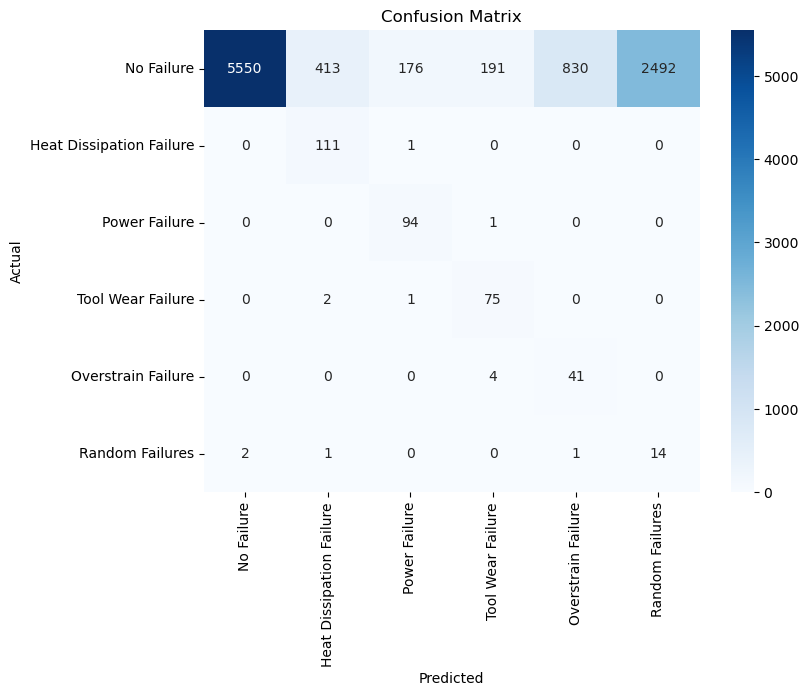

In [13]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, test_pred_adjusted), annot=True, fmt="d", cmap="Blues", 
            xticklabels=failure_mapping.values(), yticklabels=failure_mapping.values())

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Saving Final Model, Scaler and Thresholds

In [14]:
import joblib

# Save the trained model
joblib.dump(catb, "final_catboost_model.pkl")

# Save the final thresholds
joblib.dump(final_thresholds, "final_thresholds.pkl")

# Save the scaler
joblib.dump(scaler, "final_scaler.pkl")  # ✅ FIXED: Save the scaler too

print("✅ Model, scaler & thresholds saved successfully!")

✅ Model, scaler & thresholds saved successfully!
